In [1]:
# installing the folium package for maps
! pip install folium 

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import numpy as np
import seaborn as sns 
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

In [2]:
# The code was removed by Watson Studio for sharing.

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [18]:
# total number of accidents
totalaccidents = len(df_og.index)
print(F"Total Accidents: {totalaccidents}")

# total number of serious injuries overall
total_ser_inj = 0
for row in range(totalaccidents):
    if df_og['SEVERITYCODE.1'][row] >= 2:
        total_ser_inj = total_ser_inj + 1
percent_total_ser_inj = round(((total_ser_inj/totalaccidents)*100),2)
print(F"Total Serious Injuries: {total_ser_inj}, or {percent_total_ser_inj}% of the total number of accidents resulted in serious injuries")

# total number of bikes involved in accidents
totalbikes = df_og['PEDCYLCOUNT'].sum()
percent_totalbikes = round(((totalbikes/totalaccidents)*100),2)
print(F"Total Bike Accidents: {totalbikes}, or {percent_totalbikes}% of the total number of accidents")

# total number of serious injuries for accidents with bikes
total_bike_ser_inj = 0
for row in range(totalaccidents):
    if (df_og['PEDCYLCOUNT'][row] >= 1) and ((df_og['SEVERITYCODE.1'][row]) >= 2):
        total_bike_ser_inj = total_bike_ser_inj + 1
percent_total_bike_ser_inj = round(((total_bike_ser_inj/totalbikes)*100),2)
percent_bike_ser_inj_tototal = round(((total_bike_ser_inj/total_ser_inj)*100),2)
print(F"Total Bike Serious Injuries: {total_bike_ser_inj}, {percent_total_bike_ser_inj}% of the total number of bike accidents, {percent_bike_ser_inj_tototal}% of all serious injury accidents ")

Total Accidents: 194673
Total Serious Injuries: 58188, or 29.89% of the total number of accidents resulted in serious injuries
Total Bike Accidents: 5527, or 2.84% of the total number of accidents
Total Bike Serious Injuries: 4805, 86.94% of the total number of bike accidents, 8.26% of all serious injury accidents 


In [4]:
# create a bike accident and location df
df_loc_roadcond = df_og[['PEDCYLCOUNT', 'SEVERITYCODE.1', 'ADDRTYPE','ROADCOND','SDOT_COLCODE', 'X', 'Y', 'INCDATE']]
location_len= len(df_loc_roadcond.index)
df_loc_roadcond[['DATE','DROP']] = df_loc_roadcond.INCDATE.str.split(expand=True)
df_loc_roadcond['DATE'] = pd.to_datetime(df_loc_roadcond['DATE'])

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
# drop all non-bike collisions from table
df_final = df_loc_roadcond[df_loc_roadcond['PEDCYLCOUNT'] > 0]

# Set Columns for Dry and Wet Roads
df_final['Dry'] = np.where(df_final['ROADCOND'].str.contains("Dry"), True, False)
df_final['Wet'] = np.where(df_final['ROADCOND'].str.contains("Wet"), True, False)

# Set Columns for Alley, Intersections, and Block
df_final['Block'] = np.where(df_final['ADDRTYPE'].str.contains("Block"), True, False)
df_final['Intersection'] = np.where(df_final['ADDRTYPE'].str.contains("Intersection"), True, False)
df_final['Alley'] = np.where(df_final['ADDRTYPE'].str.contains("Alley"), True, False)

# drop the ADDRTYPE and ROADCOND column
df_final.drop(['ADDRTYPE', 'ROADCOND', 'INCDATE', 'DROP'], axis=1, inplace=True)

df_final.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

,PEDCYLCOUNT,SEVERITYCODE.1,SDOT_COLCODE,X,Y,DATE,Dry,Wet,Block,Intersection,Alley
7,1,2,51,-122.320780,47.614076,2020-04-15,True,False,False,True,False
25,1,2,18,-122.312857,47.599218,2019-04-25,True,False,True,False,False
52,1,2,18,-122.328913,47.613466,2013-03-29,True,False,False,True,False
79,1,1,18,-122.312464,47.652976,2013-03-28,True,False,False,True,False
90,1,2,69,-122.337054,47.695963,2004-10-11,True,False,True,False,False


In [6]:
# Bike Accidents at Blocks
block_accident = len(df_final[df_final['Block'] == True])
percent_bike_block = round(((block_accident/totalbikes)*100),2)
print(F"Bike Accidents in the Block: {block_accident}, or {percent_bike_block}% of all bike accidents")

# Bike Accidents at Intersections
inter_accident = len(df_final[df_final['Intersection'] == True])
percent_bike_inter = round(((inter_accident/totalbikes)*100),2)
print(F"Bike Accidents at Intersections: {inter_accident}, or {percent_bike_inter}% of all bike accidents")

# Bike Accidents at Intersections
alley_accident = len(df_final[df_final['Alley'] == True])
percent_bike_alley = round(((alley_accident/totalbikes)*100),2)
print(F"Bike Accidents in Allies: {alley_accident}, or {percent_bike_alley}% of all bike accidents")

Bike Accidents in the Block: 2334, or 42.23% of all bike accidents
Bike Accidents at Intersections: 3146, or 56.92% of all bike accidents
Bike Accidents in Allies: 12, or 0.22% of all bike accidents


In [7]:
# Bike Accidents on Dry Roads
dry_accident= len(df_final[df_final['Dry'] == True])
percent_bike_dry = round(((dry_accident/totalbikes)*100),2)
print(F"Bike Accidents on Dry Roads: {dry_accident}, or {percent_bike_dry}% of all bike accidents")

# Bike Accidents on Wet Roads
wet_accident= len(df_final[df_final['Wet'] == True])
percent_bike_wet = round(((wet_accident/totalbikes)*100),2)
print(F"Bike Accidents on Wet Roads: {wet_accident}, or {percent_bike_wet}% of all bike accidents")

# Bike Serious Injury Accidents on Dry Roads
serinj_dry_accident= len(df_final.loc[(df_final['Dry'] == True) & (df_final['SEVERITYCODE.1'] >= 2)])
serinj_percent_bike_dry = round(((serinj_dry_accident/total_bike_ser_inj)*100),2)
print(F"Bike Accidents on Dry Roads with Serious Injuries: {serinj_dry_accident}, or {serinj_percent_bike_dry}% of bike accidents with serious injuries")

# Bike Serious Injury Accidents on Wet Roads
serinj_wet_accident= len(df_final.loc[(df_final['Wet'] == True) & (df_final['SEVERITYCODE.1'] >= 2)])
serinj_percent_bike_wet = round(((serinj_wet_accident/total_bike_ser_inj)*100),2)
print(F"Bike Accidents on Wet Roads with Serious Injuries: {serinj_wet_accident}, or {serinj_percent_bike_wet}% of bike accidents with serious injuries")

Bike Accidents on Dry Roads: 4407, or 79.74% of all bike accidents
Bike Accidents on Wet Roads: 939, or 16.99% of all bike accidents
Bike Accidents on Dry Roads with Serious Injuries: 3900, or 81.17% of bike accidents with serious injuries
Bike Accidents on Wet Roads with Serious Injuries: 813, or 16.92% of bike accidents with serious injuries


In [8]:
# Bike accidents at Intersections on Dry Roads
dry_inter_accident = len(df_final.loc[(df_final['Dry'] == True) & (df_final['Intersection'] == True)])
percent_bike_dry_inter = round(((dry_inter_accident/totalbikes)*100),2)
percent_inter_bike_dry = round(((dry_inter_accident/inter_accident)*100),2)
print(F"Bike Accidents on Dry Roads at intersections: {dry_inter_accident}, {percent_bike_dry_inter}% of all bike accidents, or {percent_inter_bike_dry}% of all intersection accidents")

# Bike Accidents at Intersections on Wet Roads
wet_inter_accident = len(df_final.loc[(df_final['Wet'] == True) & (df_final['Intersection'] == True)])
percent_bike_wet_inter = round(((wet_inter_accident/totalbikes)*100),2)
percent_inter_bike_wet = round(((wet_inter_accident/inter_accident)*100),2)
print(F"Bike Accidents on Wet Roads at intersections: {wet_inter_accident}, {percent_bike_wet_inter}% of all bike accidents, or {percent_inter_bike_wet}% of all intersection accidents")

# Bike Serious Injury Accidents on Dry Roads at Intersections
serinj_dry_inter_accident = len(df_final.loc[(df_final['Dry'] == True) & (df_final['SEVERITYCODE.1'] >= 2) & (df_final['Intersection'] == True)])
serinj_percent_bike_dry_inter = round(((serinj_dry_inter_accident/total_bike_ser_inj)*100),2)
print(F"Bike Accidents on Dry Roads at Intersections with Serious Injuries: {serinj_dry_inter_accident}, or {serinj_percent_bike_dry_inter}% of bike accidents with serious injuries")

# Bike Serious Injury Accidents on Wet Roads at Intersections
serinj_wet_inter_accident = len(df_final.loc[(df_final['Wet'] == True) & (df_final['SEVERITYCODE.1'] >= 2) & (df_final['Intersection'] == True)])
serinj_percent_bike_wet_inter = round(((serinj_wet_inter_accident/total_bike_ser_inj)*100),2)
print(F"Bike Accidents on Wet Roads at Intersections with Serious Injuries: {serinj_wet_inter_accident}, or {serinj_percent_bike_wet_inter}% of bike accidents with serious injuries")

Bike Accidents on Dry Roads at intersections: 2479, 44.85% of all bike accidents, or 78.8% of all intersection accidents
Bike Accidents on Wet Roads at intersections: 603, 10.91% of all bike accidents, or 19.17% of all intersection accidents
Bike Accidents on Dry Roads at Intersections with Serious Injuries: 2220, or 46.2% of bike accidents with serious injuries
Bike Accidents on Wet Roads at Intersections with Serious Injuries: 524, or 10.91% of bike accidents with serious injuries


In [9]:
# importing matplotlib to do visual representations of data
import matplotlib.pyplot as plt

In [10]:
collision_counts = df_final['SDOT_COLCODE'].value_counts()
cc_index = np.array(collision_counts.index)
df_cc = pd.DataFrame(df_final['SDOT_COLCODE'].value_counts())
df_cc.insert(0,'TYPE', cc_index)
df_cc = df_cc.astype({'TYPE': str})

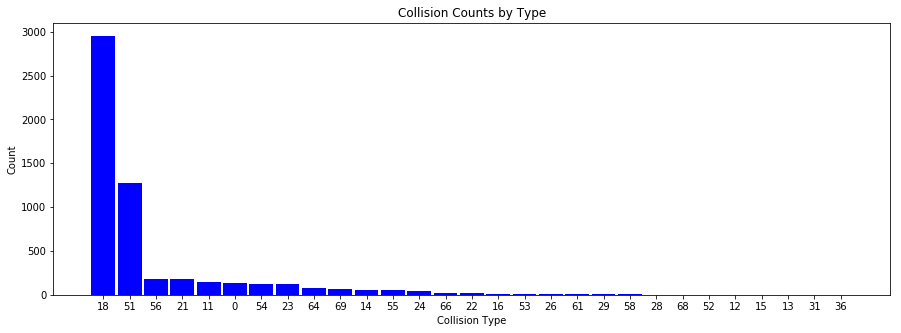

In [11]:
# Create a bar chart showing the number of collision types for total bike accidents
plt.figure(figsize=(15,5))
plt.bar(df_cc['TYPE'], df_cc['SDOT_COLCODE'] , color='blue', width = .9)
plt.title('Collision Counts by Type')
plt.xlabel('Collision Type')
plt.ylabel('Count')
plt.xticks(df_cc['TYPE'])
plt.show()

In [12]:
# Bike Accidents from Collision type 18
ctype_18_accident = len(df_final[df_final['SDOT_COLCODE'] == 18])
percent_ctype_18 = round(((ctype_18_accident/totalbikes)*100),2)
print(F"Motorist struck bike, Front End at Angle: {ctype_18_accident}, or {percent_ctype_18}% of all bike accidents")

# Bike Accidents from Collision type 51
ctype_51_accident = len(df_final[df_final['SDOT_COLCODE'] == 51])
percent_ctype_51 = round(((ctype_51_accident/totalbikes)*100),2)
print(F"Bikes struck Motorist, Front End at Angle: {ctype_51_accident}, or {percent_ctype_51}% of all bike accidents")

# Bike Accidents from Collision type 18,51,11
ctype_18_51_accident = len(df_final.loc[(df_final['SDOT_COLCODE'] == 18) ^ (df_final['SDOT_COLCODE'] == 51) ^ (df_final['SDOT_COLCODE'] == 11)])
percent_ctype_18_51 = round(((ctype_18_51_accident/totalbikes)*100),2)
print(F"Front End at Angle accidents involving a bike: {ctype_18_51_accident}, or {percent_ctype_18_51}% of all bike accidents")

Motorist struck bike, Front End at Angle: 2952, or 53.41% of all bike accidents
Bikes struck Motorist, Front End at Angle: 1277, or 23.1% of all bike accidents
Front End at Angle accidents involving a bike: 4370, or 79.07% of all bike accidents


In [13]:
# Bike accidents at Intersections on Dry Roads, code 18,51,11
dry_inter_accident1851 = len(df_final.loc[((df_final['Dry'] == True) & (df_final['Intersection'] == True) & ((df_final['SDOT_COLCODE'] == 11) ^ (df_final['SDOT_COLCODE'] == 18) ^ (df_final['SDOT_COLCODE'] == 51)))])
percent_bike_dry_inter1851 = round(((dry_inter_accident1851/totalbikes)*100),2)
percent_inter_bike_dry1851 = round(((dry_inter_accident1851/inter_accident)*100),2)
print(F"Bike Accidents at intersections, dry roads, and Front End at Angle Impact: {dry_inter_accident1851}, {percent_bike_dry_inter1851}% bike accidents, or {percent_inter_bike_dry1851}% intersection accidents")

# Bike Accidents at Intersections on Wet Roads, code 118,51,11
wet_inter_accident1851 = len(df_final.loc[((df_final['Wet'] == True) & (df_final['Intersection'] == True) & ((df_final['SDOT_COLCODE'] == 11) ^ (df_final['SDOT_COLCODE'] == 18) ^ (df_final['SDOT_COLCODE'] == 51)))])
percent_bike_wet_inter1851 = round(((wet_inter_accident1851/totalbikes)*100),2)
percent_inter_bike_wet1851 = round(((wet_inter_accident1851/inter_accident)*100),2)
print(F"Bike Accidents at intersections, wet roads, and Front End at Angle Impact: {wet_inter_accident1851}, {percent_bike_wet_inter1851}% bike accidents, or {percent_inter_bike_wet1851}% intersection accidents")

# Bike Serious Injury Accidents on Dry Roads at Intersections, code 18,51,11
serinj_dry_inter_accident1851 = len(df_final.loc[((df_final['Dry'] == True) & (df_final['SEVERITYCODE.1'] >= 2) & (df_final['Intersection'] == True) & ((df_final['SDOT_COLCODE'] == 11) ^ (df_final['SDOT_COLCODE'] == 18) ^ (df_final['SDOT_COLCODE'] == 51)))])
serinj_percent_bike_dry_inter1851 = round(((serinj_dry_inter_accident1851/total_bike_ser_inj)*100),2)
serinj_vinter_percent_bike_dry_inter1851 = round(((serinj_dry_inter_accident1851/dry_inter_accident1851)*100),2)
print(F"Bike Accidents at intersections, dry roads, and Front End at Angle Impact with Serious Injuries: {serinj_dry_inter_accident1851}, {serinj_percent_bike_dry_inter1851}% of bike accidents with serious injuries, or {serinj_vinter_percent_bike_dry_inter1851}% of bike accidents at intersections with dry roads and front angle impact")

# Bike Serious Injury Accidents on Wet Roads at Intersections, code 18,51,11
serinj_wet_inter_accident1851 = len(df_final.loc[((df_final['Wet'] == True) & (df_final['SEVERITYCODE.1'] >= 2) & (df_final['Intersection'] == True) & ((df_final['SDOT_COLCODE'] == 11) ^ (df_final['SDOT_COLCODE'] == 18) ^ (df_final['SDOT_COLCODE'] == 51)))])
serinj_percent_bike_wet_inter1851 = round(((serinj_wet_inter_accident1851/total_bike_ser_inj)*100),2)
print(F"Bike Accidents at intersections, wet roads, and Front End at Angle Impact with Serious Injuries: {serinj_wet_inter_accident1851}, or {serinj_percent_bike_wet_inter1851}% of bike accidents with serious injuries")

Bike Accidents at intersections, dry roads, and Front End at Angle Impact: 2276, 41.18% bike accidents, or 72.35% intersection accidents
Bike Accidents at intersections, wet roads, and Front End at Angle Impact: 562, 10.17% bike accidents, or 17.86% intersection accidents
Bike Accidents at intersections, dry roads, and Front End at Angle Impact with Serious Injuries: 2041, 42.48% of bike accidents with serious injuries, or 89.67% of bike accidents at intersections with dry roads and front angle impact
Bike Accidents at intersections, wet roads, and Front End at Angle Impact with Serious Injuries: 490, or 10.2% of bike accidents with serious injuries


In [14]:
# create df with intersection accidents and SDOT_COLCODE 18 and 51 
df_final185111 = df_final.loc[((df_final['SDOT_COLCODE'] == 11) ^ df_final['SDOT_COLCODE'] == 18 ^ (df_final['SDOT_COLCODE'] == 51)) & (df_final['Intersection'] == True)]
df_final185111.drop(['Alley', 'Block'], axis=1, inplace=True)
df_final185111.dropna
df_final185111.sort_values(by=['DATE'], inplace=True)
df_final185111.reset_index(inplace=True)
df_final185111.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,index,PEDCYLCOUNT,SEVERITYCODE.1,SDOT_COLCODE,X,Y,DATE,Dry,Wet,Intersection
0,6931,1,2,51,-122.347372,47.612710,2004-01-05,True,False,True
1,4442,1,2,18,-122.320080,47.637252,2004-01-11,True,False,True
2,5865,1,2,18,-122.309516,47.699413,2004-01-12,True,False,True
3,12835,1,2,18,-122.354405,47.669109,2004-01-12,False,True,True
4,3825,1,2,51,-122.335110,47.701412,2004-01-29,False,True,True


In [15]:
# set base map of seattle
base_map = folium.Map(location=[47.603646, -122.339223], zoom_start=11)
heat_map = base_map
heattime_map = base_map

In [16]:
# Ensure you're handing it floats
df_final185111['Y'] = df_final185111['Y'].astype(float)
df_final185111['X'] = df_final185111['X'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = df_final185111
heat_df = heat_df[['Y', 'X', 'DATE']]
heat_df = heat_df.dropna(axis=0, subset=['Y','X', 'DATE'])

# List comprehension to make out list of lists
heat_data = [[row['Y'],row['X']] for index, row in heat_df.iterrows()]

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [17]:
# Plot it on the map
HeatMap(heat_data, min_opacity=0.5, max_val=3, blur=2).add_to(heat_map)

# Display the map
heat_map